# Crosslight Detection Convolutional Neural Network

## Creating generators for training and validation data

In this section, we create two image data generators. The training generator takes an image and applies some simple augmentation by the defined transformations in test_datagen(implementation in next section). We implemented some simple zooming, shifting, and rotation. This helps us to get a lot of unique images out of a small dataset of images. Below we provided some generated samples to make clear what the data augmentation does. In addition, we have a test image data generator. This generator simply takes the image and rescales by 1./255. When we validate or test the network we don't want to manipulate real world data.

After the generators have been created we serve them images from our directory ../images/crosslight/train and ../images/crosslight/validation. Every subfolder in this directory will be transformed to a feature. Because this network uses a binary classifier we need to make sure that there are only two subfolders available, red and green.

### Generators

In [5]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 256
image_height = 128
image_width = 128

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.10,
        height_shift_range=0.10,
        rescale=1./255,
        shear_range=0.10,
        zoom_range=0.10,
        horizontal_flip=False,
        fill_mode='nearest')

# this is the configuration we will use for testing:
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'iamges/crosslight/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        '../images/crosslight/train',
        target_size=(image_height, image_width),
        batch_size=batch_size,
        class_mode='binary')

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        '../images/crosslight/validation',
        target_size=(image_height, image_width),
        batch_size=batch_size,
        class_mode='binary')


Found 240 images belonging to 2 classes.
Found 24 images belonging to 2 classes.


### Sample augmented images

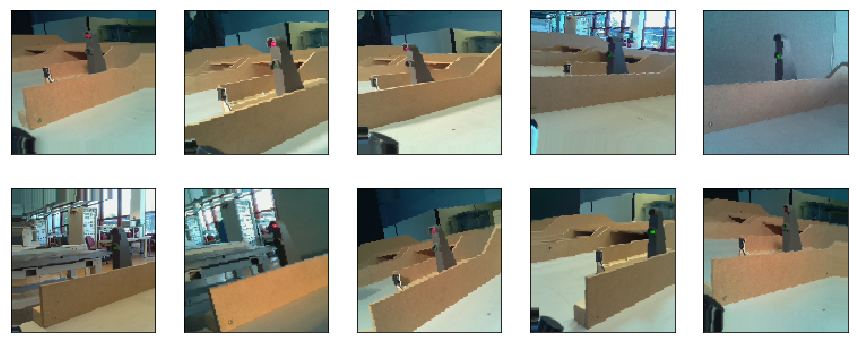

In [2]:
import matplotlib.pyplot as plt

stop = 1
plt.figure(figsize=(15, 6))
n = 5

for batch in train_generator:
    # display original
    ax = plt.subplot(2, n, stop)
    plt.imshow(batch[0][0])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    stop += 1
    if stop > 10:
        break
plt.show()


## Defining our Convolutional Neural Network model

In the next section, we define the layers of our convolutional neural network. The basic of deep learning is stacking a lot of layers on top of each other to create a deep and more robust neural network. We have implemented three layers Convolutional 2D with rectifier activation and max pooling. This is a best practice method and used in known nets like VGG16 / VGG19. Afterward, we flatten our filters and add a dense (normal neural network layer) with rectifier activation. To prevent our network from overfitting there is a dropout layer and the final dense sigmoid layer to see probability distribution on the possible outcomes. Our model summary shows how many parameters we need for the network. In order to have a good performance on a raspberry pi, we trim the network to the least parameters we could.

In [3]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, Dense


model = Sequential()
model.add(Conv2D(8, (3, 3), activation='relu', padding='same', name='block1_conv1', input_shape=(image_height, image_width, 3)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='block1_pool'))

model.add(Conv2D(8, (3, 3), activation='relu', padding='same', name='block2_conv1'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='block2_pool'))

model.add(Conv2D(8, (3, 3), activation='relu', padding='same', name='block3_conv1'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='block3_pool'))

# the model so far outputs 3D feature maps (height, width, features)

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.7))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


### Display how many parameters have been used

In [4]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 128, 128, 8)       224       
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 8)         0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 8)         584       
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 8)         0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 32, 32, 8)         584       
_________________________________________________________________
block3_pool (MaxPooling2D)   (None, 16, 16, 8)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
__________

## Train the network

Finally, we feed the data from the generators to our network. Our training procedure contains hundred iterations training and then we validate on real world data that is not used for training. This helps us determine if the network works with images it has not seen before. After training we save our model weights to ../models/crosslight.h5

In [8]:
model.fit_generator(
        train_generator,
        steps_per_epoch=10,
        epochs=5,
        validation_data=validation_generator,
        verbose=1,
        validation_steps=1)

Epoch 1/5
10/10 [==============================] - 7s - loss: 0.0069 - acc: 0.9983 - val_loss: 1.8978e-05 - val_acc: 1.0000
Epoch 2/5
10/10 [==============================] - 7s - loss: 0.0077 - acc: 0.9996 - val_loss: 1.0324e-05 - val_acc: 1.0000
Epoch 3/5
10/10 [==============================] - 7s - loss: 0.0120 - acc: 0.9979 - val_loss: 8.5888e-06 - val_acc: 1.0000
Epoch 4/5
10/10 [==============================] - 7s - loss: 0.0073 - acc: 0.9983 - val_loss: 9.3747e-05 - val_acc: 1.0000
Epoch 5/5
10/10 [==============================] - 7s - loss: 0.0055 - acc: 0.9996 - val_loss: 1.2968e-05 - val_acc: 1.0000


### Save our network weights

In [6]:
model.save_weights('../models/crosslight.h5')

In [6]:
model.load_weights('../models/crosslight.h5')

## Test the network

Our network is finally trained and contains all the knowledge to classify new images. In this step, we test the network on its knowledge. All images are new to the network so it can not know them from the past. We make a prediction for every image and will see how good it performs. This is like our final exam to determine if the learning process was successful or not.

In [10]:
test_generator = test_datagen.flow_from_directory(
        '../images/crosslight/test',
        target_size=(image_height, image_width),
        batch_size=batch_size,
        class_mode='binary')

Found 26 images belonging to 2 classes.


In [11]:
model.evaluate_generator(
        test_generator,
        steps=100)

[1.8462371353962226e-05, 1.0]

We can see that our network can detect the crosslight with a 100% accuracy on the test data. This validates our network so we can use it in production.